# Global Equity Portfolio Optimization and External Manager Allocation

## Introduction

The Global Equity portfolio invested in 5 external managers and 2 subportfolios managed internally. The portfolio is designed to generate long term investment return while maintain moderate risk compared to benchmark MSCI World Index.

During the past years, the performance of the portfolio is not perfoming as expected. To better understand how to allocate capital in different fund managers, I perform the portfolio opimization technique to get the highest possible returns, sharp ratios, with given risk. 

Based on the opitmal weights, we backtest the performance on different weighted portfolios. We found that the current portfolio is not the best performed one.

Notice that the estimated return is based on history data which could be challenged.



In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


def equal_weight(assets):
    optimal = [1/len(assets) for i in range(len(assets))]
    return optimal


def minimum_variance(ret, bound):
    def find_port_variance(weights):
        # this is actually std
        cov = ret.cov()
        port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)) * 250)
        return port_var

    def weight_cons(weights):
        return np.sum(weights) - 1


    bounds_lim = [bound for x in range(len(ret.columns))] # change to (-1, 1) if you want to short
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    constraint = {'type': 'eq', 'fun': weight_cons}

    optimal = minimize(fun=find_port_variance,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])


def max_sharpe(ret, bound):
    def sharpe_func(weights):
        hist_mean = ret.mean(axis=0).to_frame()
        hist_cov = ret.cov()

        port_ret = np.dot(weights.T, hist_mean.values) * 250
        port_std = np.sqrt(np.dot(weights.T, np.dot(hist_cov, weights)) * 250)
        return -1 * port_ret / port_std

    def weight_cons(weights):
        return np.sum(weights) - 1


    bounds_lim = [bound for x in range(len(ret.columns))] # change to (-1, 1) if you want to short
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    constraint = {'type': 'eq', 'fun': weight_cons}

    optimal = minimize(fun=sharpe_func,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])

def minimum_trackingerror(ret, benchmark_ret, bound):
    def tracking_error(weights):
        tracking_difference = ret - benchmark_ret
        cov = tracking_difference.cov()
        tracking_error = np.sqrt(np.dot(weights.T, np.dot(cov, weights))*250)        
        return tracking_error

    def weight_cons(weights):
        return np.sum(weights)-1

    
    bounds_lim = [bound for x in range(len(ret.columns))] # change to (-1, 1) if you want to short
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    constraint = {'type': 'eq', 'fun': weight_cons}

    optimal = minimize(fun=tracking_error,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )
    return list(optimal['x'])

## Weights Optimization

There are three metrics defined above, **tracking error**, **variance** and **sharp ratio**. They are the most popular risk metrics and performance index referred by portfolio managers. 

Initially, assign equal weight for each sub-fund and define the range of the weights which can vary between 0 to 1 for long only strategy. Then apply Sequential Least Squares Programming method to find the minimum tracking error portfolio, minimum variance portfolio and maximized sharp ratio portfolio.

Download the data from Bloomberg for each sub-portfolio's performance as well as the benchmark's performance. 



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize



# TICKERS = ['QQQ', 'TQQQ', 'TMF']
# Technology, Consumers, Industrial, Materials, Financials, Energy, Healthcare
TICKERS = ['VGT', 'VDC', 'VIS', 'VAW', 'VFH', 'VDE', 'VHT']
TOTAL_BALANCE = 10000
start_date = '2015-01-01'
end_date = '2024-12-27'
bound = (0, 1) # bounds, change to (-1, 1) if shorting is allowed


# Retrieve historical prices and calculate returns
hist_prices = yf.download(tickers=TICKERS, start=start_date, end=end_date)["Close"]
hist_prices.dropna(axis=0)
hist_return = np.log(hist_prices / hist_prices.shift())
hist_return.dropna(axis=0)

# Calculating mean (expected returns), covariance (expected volatility), and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()
print(hist_mean.T)
print(hist_cov)




[*********************100%***********************]  7 of 7 completed

Ticker       VAW       VDC       VDE       VFH       VGT       VHT       VIS
mu      0.000302  0.000318  0.000163  0.000435  0.000767  0.000342  0.000419
Ticker       VAW       VDC       VDE       VFH       VGT       VHT       VIS
Ticker                                                                      
VAW     0.000177  0.000082  0.000179  0.000158  0.000141  0.000103  0.000152
VDC     0.000082  0.000084  0.000078  0.000084  0.000083  0.000071  0.000081
VDE     0.000179  0.000078  0.000368  0.000187  0.000131  0.000100  0.000167
VFH     0.000158  0.000084  0.000187  0.000200  0.000142  0.000107  0.000159
VGT     0.000141  0.000083  0.000131  0.000142  0.000219  0.000119  0.000142
VHT     0.000103  0.000071  0.000100  0.000107  0.000119  0.000118  0.000102
VIS     0.000152  0.000081  0.000167  0.000159  0.000142  0.000102  0.000159


In [19]:
# calculate portfolio returns, standard deviation (volatility), and sharpe ratio
def portfolio_return(weights, mean):
    portfolio_return = np.dot(weights.T, mean.values) * 250 # annualize data; ~250 trading days in a year
    return portfolio_return[0]

def portfolio_std(weights, covariance):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)) * 250)
    return portfolio_std
    
def portfolio_sharpe(returns, std):
    return returns / std

---------- Equally Weighted Portfolio ----------
Weights: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
Return: 0.09809272377027493
Volatility: 0.18152785518675485
Sharpe Ratio: 0.5403728461913335

---------- Global Minimum Variance ----------
Weights: [1.56523375e-17 7.80020021e-01 0.00000000e+00 0.00000000e+00
 6.94692506e-18 2.19979979e-01 1.14533739e-17]
Return: 0.08085982805456314
Volatility: 0.1424497036206464
Sharpe Ratio: 0.5676377415982455

---------- Max Sharpe Ratio ----------
Weights: [0.00000000e+00 1.46017770e-01 0.00000000e+00 0.00000000e+00
 8.53982230e-01 9.82233051e-17 0.00000000e+00]
Return: 0.17532843345538016
Volatility: 0.21354497102883363
Sharpe Ratio: 0.8210375201563828


[*********************100%***********************]  1 of 1 completed


KeyError: 0

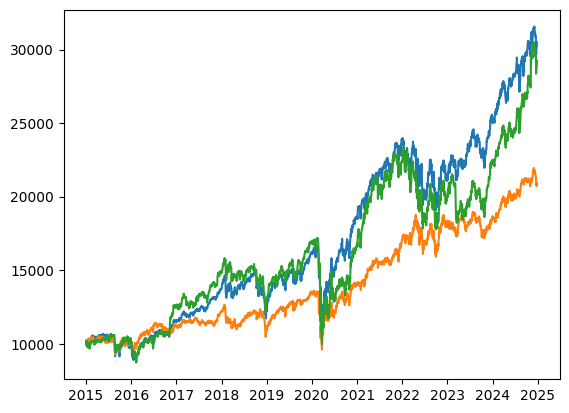

In [20]:
# simulate randomized portfolios
n_portfolios = 2000
portfolio_returns = []
portfolio_stds = []

for i in range(n_portfolios):
    weights = np.random.rand(len(TICKERS))
    weights = weights / sum(weights)
    port_return = portfolio_return(weights, hist_mean)
    port_std = portfolio_std(weights, hist_cov)
    sharpe_ratio = portfolio_sharpe(port_return, port_std)

    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)

#------------ Optimized portfolios ------------------#

#----------- Equally Weighted Portfolio -------------#
equally_weighted_weights = np.array(equal_weight(TICKERS))
equally_weighted_return = portfolio_return(equally_weighted_weights, hist_mean)
equally_weighted_std = portfolio_std(equally_weighted_weights, hist_cov)
equally_weighted_sharpe_ratio = portfolio_sharpe(equally_weighted_return, equally_weighted_std)

print('---------- Equally Weighted Portfolio ----------')
print('Weights:', equally_weighted_weights)
print('Return:', equally_weighted_return)
print('Volatility:', equally_weighted_std)
print('Sharpe Ratio:', equally_weighted_sharpe_ratio)

print()

#----------- Global Minimum Variance Portfolio ------#
gmv_weights = np.array(minimum_variance(hist_return, bound))
gmv_return = portfolio_return(gmv_weights, hist_mean)
gmv_std = portfolio_std(gmv_weights, hist_cov)
gmv_sharpe_ratio = portfolio_sharpe(gmv_return, gmv_std)

print('---------- Global Minimum Variance ----------')
print('Weights:', gmv_weights)
print('Return:', gmv_return)
print('Volatility:', gmv_std)
print('Sharpe Ratio:', gmv_sharpe_ratio)

print()
#----------- Max Sharpe Portfolio ------#
max_sharpe_weights = np.array(max_sharpe(hist_return, bound))
max_sharpe_return = portfolio_return(max_sharpe_weights, hist_mean)
max_sharpe_std = portfolio_std(max_sharpe_weights, hist_cov)
max_sharpe_sharpe_ratio = portfolio_sharpe(max_sharpe_return, max_sharpe_std)

print('---------- Max Sharpe Ratio ----------')
print('Weights:', max_sharpe_weights)
print('Return:', max_sharpe_return)
print('Volatility:', max_sharpe_std)
print('Sharpe Ratio:', max_sharpe_sharpe_ratio)

#----------- Efficient Frontier ------#
target_returns = np.linspace(0.06, 0.17, 100)
efficient_frontier_risk = []
for ret in target_returns:
    optimal = minimize(
                fun=portfolio_std,
                args=hist_cov,
                x0=equally_weighted_weights,
                bounds=[bound for x in range(len(TICKERS))],
                constraints=(
                    {'type': 'eq', 'fun': lambda x: portfolio_return(x, hist_mean) - ret},
                    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
                ),
                method='SLSQP'
            )
    efficient_frontier_risk.append(optimal['fun'])


# Print out portfolio value over time
date_range = []
equally_weighted_portfolio = []
gmv_portfolio = []
max_sharpe_portfolio = []
FINAL_BALANCE = 0

for index, day in hist_prices.iterrows():
    equal_weighted_port_val = 0
    gmv_port_val = 0
    max_sharpe_port_val = 0
    for i, asset in enumerate(TICKERS):
        equal_weighted_port_val += equally_weighted_weights[i] * TOTAL_BALANCE / hist_prices[asset].iloc[1] * day[asset]
        gmv_port_val += gmv_weights[i] * TOTAL_BALANCE / hist_prices[asset].iloc[1] * day[asset]
        max_sharpe_port_val += max_sharpe_weights[i] * TOTAL_BALANCE / hist_prices[asset].iloc[1] * day[asset]

    date_range.append(index)
    equally_weighted_portfolio.append(equal_weighted_port_val)
    gmv_portfolio.append(gmv_port_val)
    max_sharpe_portfolio.append(max_sharpe_port_val)


plt.plot(date_range, equally_weighted_portfolio, label='equally weighted portfolio')
plt.plot(date_range, gmv_portfolio, label='global min variance portfolio')
plt.plot(date_range, max_sharpe_portfolio, label='max sharpe portfolio')

# SPY for comparison
spy_prices = yf.download(tickers='SPY', start=start_date, end=end_date)['Close']
spy_prices.dropna(axis=0)
spy_portfolio = []

for price in spy_prices:
    spy_port_val = TOTAL_BALANCE / spy_prices[0] * price
    spy_portfolio.append(spy_port_val)
# print(spy_portfolio[:10], spy_portfolio[-6:])
plt.plot(date_range, spy_portfolio, label='SPY')
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value in dollars')
plt.legend()
plt.show()



# Display portfolios
plt.scatter(portfolio_stds, portfolio_returns, marker='o', s=3, label='Random')
plt.plot(efficient_frontier_risk, target_returns, 'og', markersize=3, label='Efficient Frontier')
plt.plot(equally_weighted_std, equally_weighted_return, 'or', label='Equally Weighted')
plt.plot(gmv_std, gmv_return, 'oc', label='Global Minimum Variance')
plt.plot(max_sharpe_std, max_sharpe_return, 'om', label='Max Sharpe')
plt.title('Volatility vs Returns for Different Portfolios')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.legend()
plt.show()